<a href="https://colab.research.google.com/github/alexshtf/alexshtf.github.io/blob/master/assets/bernstein_scikit_inter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install --upgrade scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4


# Basis transformers

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from itertools import combinations


class PolynomialBasisTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, degree=5, bias=False, na_value=0., interactions=False):
        self.degree = degree
        self.bias = bias
        self.na_value = na_value
        self.interactions = interactions

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Check if X is a Pandas DataFrame and convert to NumPy array
        if hasattr(X, 'values'):
            X = X.values

        # Ensure X is a 2D array
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        # Get the number of columns in the input array
        n_rows, n_features = X.shape

        # Compute the specific polynomial basis for each column
        basis_features = [
            self.feature_matrix(X[:, i])
            for i in range(n_features)
        ]

        # create interaction features - basis tensor products
        if self.interactions:
          interaction_features = [
              (u[:, None, :] * v[:, :, None]).reshape(n_rows, -1)
              for u, v in combinations(basis_features, 2)
          ]
          result_basis = interaction_features
        else:
          result_basis = basis_features

        if not self.bias:
          result_basis = [basis[:, 1:] for basis in result_basis]

        return np.hstack(result_basis)


    def feature_matrix(self, column):
      vander = self.vandermonde_matrix(column)
      return np.nan_to_num(vander, self.na_value)


    def vandermonde_matrix(self, column):
        raise NotImplementedError("Subclasses must implement this method.")

In [ ]:
import numpy.polynomial.polynomial as poly
from scipy.stats import binom


class BernsteinFeatures(PolynomialBasisTransformer):
    def vandermonde_matrix(self, column):
        basis_idx = np.arange(1 + self.degree)
        basis = binom.pmf(basis_idx, self.degree, column[:, None])
        return basis


class PowerBasisFeatures(PolynomialBasisTransformer):
    def vandermonde_matrix(self, column):
        return poly.polyvander(column, self.degree)


class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, na_value=0.):
      self.na_value = na_value

    def fit(self, input_array, y=None):
        return self

    def transform(self, input_array, y=None):
        return np.where(np.isnan(input_array), self.na_value, input_array)

## Test out the transformers on one and two columns

In [ ]:
import pandas as pd
pd.set_option('display.width', 1024)
pd.set_option('display.max_colwidth', 1024)
np.set_printoptions(precision=4)

pbt = BernsteinFeatures(degree=2).fit(np.empty(0))
bbt = PowerBasisFeatures(degree=2).fit(np.empty(0))

In [ ]:
# transform a column - output the Vandermonde matrix according to each basis
feature = np.array([0, 0.5, 1, np.nan])
print(pd.DataFrame.from_dict({
    'Feature': feature,
    'Power basis': list(pbt.transform(feature)),
    'Bernstein basis': list(bbt.transform(feature))
}))

   Feature                 Power basis Bernstein basis
0      0.0                  [0.0, 0.0]      [0.0, 0.0]
1      0.5  [0.5000000000000002, 0.25]     [0.5, 0.25]
2      1.0                  [0.0, 1.0]      [1.0, 1.0]
3      NaN                  [0.0, 0.0]      [0.0, 0.0]


In [ ]:
# transform two columns - concatenate the Vandermonde matrices
features = np.array([
    [0, 0.25],
    [0.5, 0.5],
    [np.nan, 0.75]
])
print(pd.DataFrame.from_dict({
    'Feature 0': features[:, 0],
    'Feature 1': features[:, 1],
    'Power basis': list(pbt.transform(features)),
    'Bernstein basis': list(bbt.transform(features))
}))

   Feature 0  Feature 1                                           Power basis           Bernstein basis
0        0.0       0.25                             [0.0, 0.0, 0.375, 0.0625]  [0.0, 0.0, 0.25, 0.0625]
1        0.5       0.50  [0.5000000000000002, 0.25, 0.5000000000000002, 0.25]    [0.5, 0.25, 0.5, 0.25]
2        NaN       0.75                             [0.0, 0.0, 0.375, 0.5625]  [0.0, 0.0, 0.75, 0.5625]


# Pipeline training components

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

def training_pipeline(basis_transformer, model_estimator,
                      categorical_features, numerical_features,
                      passthrough_features=[]):
  basis_feature_transformer = Pipeline([
      ('scaler', MinMaxScaler(clip=True)),
      ('basis', basis_transformer)
  ])

  categorical_transformer = OneHotEncoder(
      sparse_output=False,
      handle_unknown='infrequent_if_exist',
      min_frequency=10
  )

  preprocessor = ColumnTransformer(
      transformers=[
        ('numerical', basis_feature_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features),
        ('passthrough', 'passthrough', passthrough_features)
      ]
  )

  return Pipeline([
    ('preprocessor', preprocessor),
    ('model', model_estimator)
  ])

## Hyperparameter tuning components

In [ ]:
from sklearn.linear_model import Ridge

pipeline = training_pipeline(BernsteinFeatures(), Ridge(), [], [])
print({k:v for k,v in pipeline.get_params().items()
           if 'degree' in k or 'alpha' in k})

{'preprocessor__numerical__basis__degree': 5, 'model__alpha': 1.0}


In [ ]:
from sklearn.model_selection import cross_val_score

class TuningObjective:
  def __call__(self, pipeline, metric, train_df, target, params):
    self.set_params(pipeline, params)
    scores = cross_val_score(pipeline, train_df, train_df[target], scoring=metric)
    return -np.mean(scores)

  def set_params(self, pipeline, params):
    pipeline.set_params(**params)

In [ ]:
from hyperopt import fmin, tpe
from sklearn.metrics import get_scorer

def tune_and_evaluate_pipeline(pipeline, param_space,
                               train_df, test_df, target, metric,
                               tuning_objective=TuningObjective(),
                               max_evals=100, random_seed=42):
  print('Tuning params')
  def bound_tuning_objective(params):
    return tuning_objective(pipeline, metric, train_df, target, params)

  params = fmin(fn=bound_tuning_objective, # <-- this is the objective
                space=param_space,         # <-- the search space
                algo=tpe.suggest,          # <-- the algorithm to use. TPE is the most widely used.
                max_evals=max_evals,       # <-- maximum number of configurations to try
                rstate=np.random.default_rng(random_seed),
                return_argmin=False)
  print(f'Best params = {params}')

  print('Refitting with best params on the entire training set')
  tuning_objective.set_params(pipeline, params)
  model = pipeline.fit(train_df, train_df[target])

  scorer = get_scorer(metric)
  score = scorer(model, test_df, test_df[target])
  print(f'Test metric = {score:.5f}')

  return model

# Train models on the california housing dataset

In [ ]:
train_df = pd.read_csv('sample_data/california_housing_train.csv')
test_df = pd.read_csv('sample_data/california_housing_test.csv')

In [ ]:
len(train_df), len(test_df)

(17000, 3000)

In [ ]:
print(train_df.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  population  households  median_income  median_house_value
0    -114.31     34.19                15.0       5612.0          1283.0      1015.0       472.0         1.4936             66900.0
1    -114.47     34.40                19.0       7650.0          1901.0      1129.0       463.0         1.8200             80100.0
2    -114.56     33.69                17.0        720.0           174.0       333.0       117.0         1.6509             85700.0
3    -114.57     33.64                14.0       1501.0           337.0       515.0       226.0         3.1917             73400.0
4    -114.57     33.57                20.0       1454.0           326.0       624.0       262.0         1.9250             65500.0


In [ ]:
import sklearn.utils

train_df = sklearn.utils.shuffle(train_df, random_state=42)

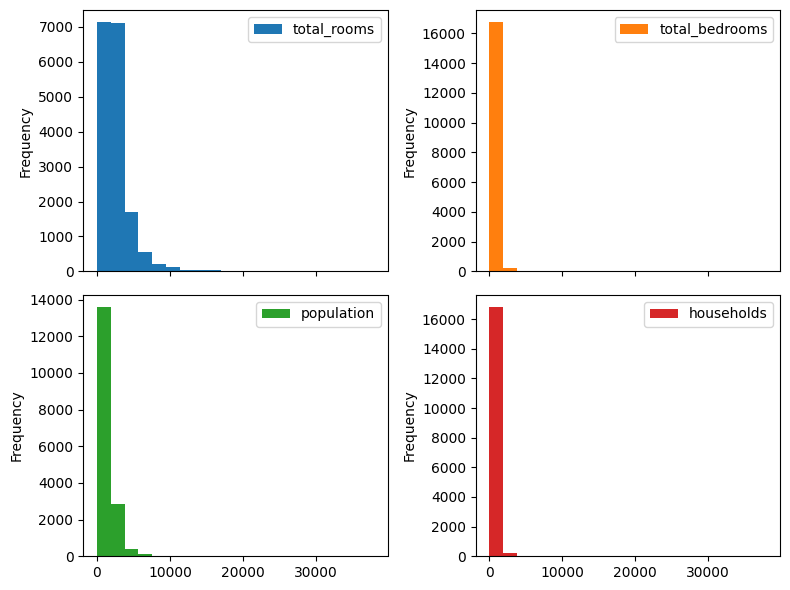

In [ ]:
skewed_columns = ['total_rooms', 'total_bedrooms', 'population', 'households']
axs = train_df.loc[:, skewed_columns].plot.hist(
    bins=20, subplots=True, layout=(2, 2), figsize=(8, 6))
axs.flat[0].get_figure().tight_layout()

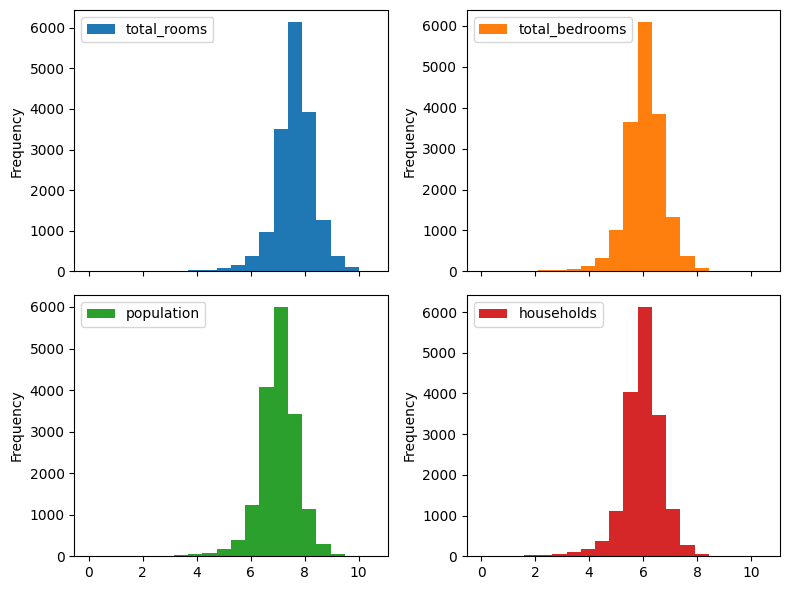

In [ ]:
axs = train_df.loc[:, skewed_columns].apply(np.log).plot.hist(
    bins=20, subplots=True, layout=(2, 2), figsize=(8, 6))
axs.flat[0].get_figure().tight_layout()

In [ ]:
train_df.loc[:, skewed_columns] = train_df[skewed_columns].apply(np.log)
test_df.loc[:, skewed_columns] = test_df[skewed_columns].apply(np.log)

In [ ]:
print(train_df.tail())

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  population  households  median_income  median_house_value
11284    -121.13     37.74                21.0     7.773174        6.163315    7.069023    6.089045         3.6016            134600.0
11964    -121.38     38.62                41.0     6.651572        4.969813    5.874931    5.010635         3.5625            115300.0
5390     -118.15     33.91                38.0     6.803505        5.323010    6.633318    5.337538         2.9643            147400.0
860      -117.07     32.56                 9.0     8.201934        6.796824    8.099554    6.733402         3.0992            142600.0
15795    -122.41     37.75                52.0     7.804659        6.434547    7.566311    6.308098         2.3903            236100.0


In [ ]:
print(test_df.tail())

      longitude  latitude  housing_median_age  total_rooms  total_bedrooms  population  households  median_income  median_house_value
2995    -119.86     34.42                23.0     7.279319        6.464588    7.137278    6.408529         1.1790            225000.0
2996    -118.14     34.06                27.0     8.567316        6.986566    8.159375    6.943122         3.3906            237200.0
2997    -119.70     36.30                10.0     6.862758        5.303305    6.541030    5.393628         2.2895             62000.0
2998    -117.12     34.10                40.0     4.564348        2.639057    3.828641    2.639057         3.2708            162500.0
2999    -119.63     34.42                42.0     7.475906        5.572154    6.624065    5.560682         8.5608            500001.0


In [ ]:
categorical_features = ['housing_median_age']
numerical_features = ['longitude', 'latitude', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
target = ['median_house_value']

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor


def california_housing_pipeline(basis_transformer):
    return training_pipeline(
        basis_transformer,
        TransformedTargetRegressor(
            regressor=Ridge(),
            transformer=MinMaxScaler()
        ),
        categorical_features,
        numerical_features
    )

## Linear model

In [ ]:
from hyperopt import hp

linear_param_space = {
    'model__regressor__alpha': hp.loguniform('C', -10, 5)
}

linear_pipeline = california_housing_pipeline(IdentityTransformer())
linear_fit_result = tune_and_evaluate_pipeline(linear_pipeline, linear_param_space,
                                               train_df, test_df, target,
                                               'neg_root_mean_squared_error')

Tuning params
100%|██████████| 100/100 [00:58<00:00,  1.70trial/s, best loss: 66571.41296769111]
Best params = {'model__regressor__alpha': 0.014451874382927206}
Refitting with best params on the entire training set
Test metric = -67627.05288


## Polynomial models

In [ ]:
poly_param_space = {
    'preprocessor__numerical__basis__degree': hp.uniformint('degree', 1, 64),
    'model__regressor__alpha': hp.loguniform('C', -10, 5)
}

bernstein_pipeline = california_housing_pipeline(BernsteinFeatures())
bernstein_fit_result = tune_and_evaluate_pipeline(
    bernstein_pipeline, poly_param_space,
    train_df, test_df, target,
    'neg_root_mean_squared_error')

Tuning params
100%|██████████| 100/100 [10:22<00:00,  6.23s/trial, best loss: 60215.16853109548]
Best params = {'model__regressor__alpha': 0.008508479829912808, 'preprocessor__numerical__basis__degree': 64}
Refitting with best params on the entire training set
Test metric = -61421.45765


In [ ]:
power_basis_pipeline = california_housing_pipeline(PowerBasisFeatures())
power_basis_fit_result = tune_and_evaluate_pipeline(
    power_basis_pipeline, poly_param_space,
    train_df, test_df, target,
    metric='neg_root_mean_squared_error')

Tuning params
100%|██████████| 100/100 [02:53<00:00,  1.73s/trial, best loss: 62169.15548756665]
Best params = {'model__regressor__alpha': 4.683664511166619e-05, 'preprocessor__numerical__basis__degree': 61}
Refitting with best params on the entire training set
Test metric = -63530.46548


## Trained model inspection

In [ ]:
def get_coefs(pipeline):
  model = pipeline.named_steps['model']
  return model.regressor_.coef_.ravel()

In [ ]:
import matplotlib.pyplot as plt
import math

def plot_feature_curves(pipeline, basis_transformer_ctor, numerical_features,
                        plot_control_pts=True):
  # get the coefficients and the degree
  degree = pipeline.get_params()['preprocessor__numerical__basis__degree']
  coefs = get_coefs(pipeline)

  # extract the numerical features, and form a matrix, such that the
  # coefficients of each feature is in a separate row.
  numerical_slice = pipeline.get_params()['preprocessor'].output_indices_['numerical']
  feature_coefs = coefs[numerical_slice].reshape(-1, degree)

  # form the basis Vandermonde matrix on [0, 1]
  xs = np.linspace(0, 1, 1000)
  xs_vander = basis_transformer_ctor(degree=degree).fit_transform(xs)

  # do the plotting
  n_cols = 3
  n_rows = math.ceil(len(numerical_features) / n_cols)
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
  for i, (ax, coefs) in enumerate(zip(axs.ravel(), feature_coefs)):
    if plot_control_pts:
      control_xs = (1 + np.arange(len(coefs))) / len(coefs)
      ax.scatter(control_xs, coefs, s=30, facecolors='none', edgecolor='b', alpha=0.5)
    ax.plot(xs, xs_vander @ coefs)
    ax.set_title(numerical_features[i])
  fig.show()

In [ ]:
dict(zip(
    numerical_features,
    get_coefs(linear_fit_result)[:len(numerical_features)]
))

{'longitude': -0.8601878267614308,
 'latitude': -0.8223342969237596,
 'total_rooms': -1.1081179198303261,
 'total_bedrooms': 1.8219013712564003,
 'population': -1.840449318220462,
 'households': 0.9726666391766497,
 'median_income': 1.2987051896630026}

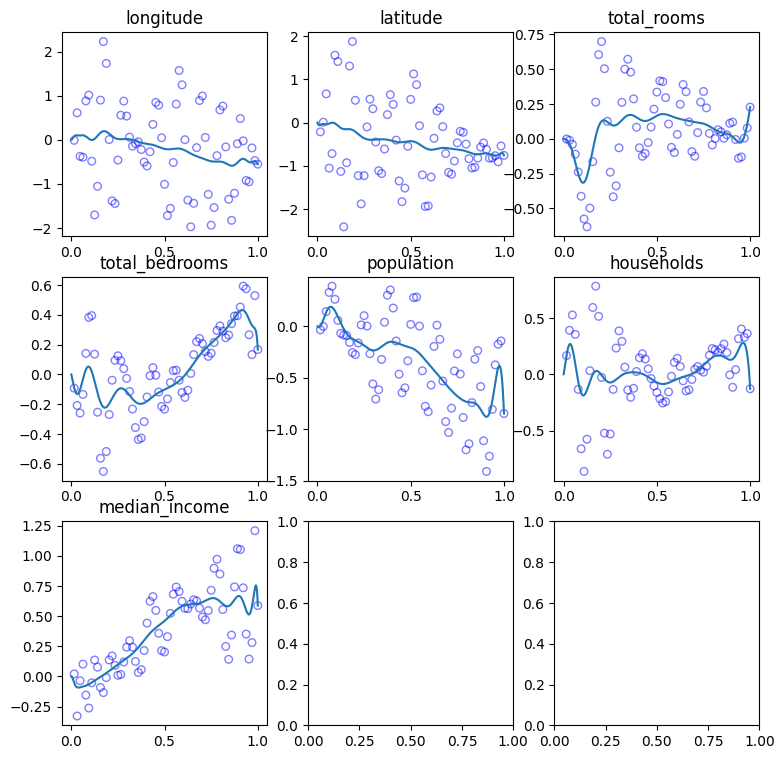

In [ ]:
plot_feature_curves(bernstein_fit_result, BernsteinFeatures, numerical_features)

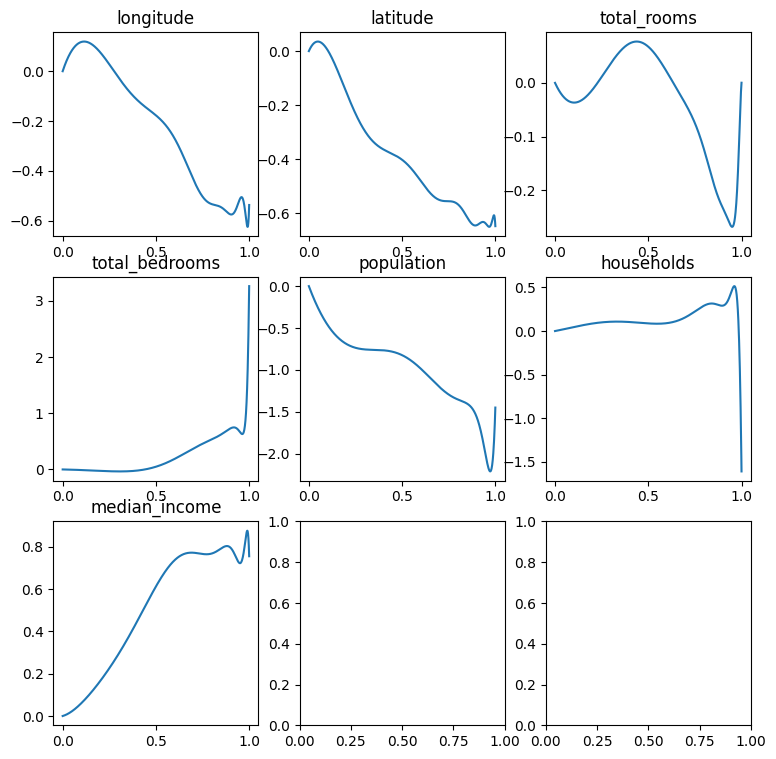

In [ ]:
plot_feature_curves(power_basis_fit_result, PowerBasisFeatures, numerical_features, plot_control_pts=False)

## Interaction models

In [ ]:
inter_param_space = {
    'preprocessor__numerical__basis__degree': hp.uniformint('degree', 1, 8),
    'model__regressor__alpha': hp.loguniform('C', -10, 5)
}

bernstein_inter_pipeline = california_housing_pipeline(BernsteinFeatures(interactions=True))
tune_and_evaluate_pipeline(bernstein_inter_pipeline, inter_param_space,
                           train_df, test_df, target,
                           'neg_root_mean_squared_error')

Tuning params
100%|██████████| 100/100 [14:09<00:00,  8.50s/trial, best loss: 55558.90453947183]
Best params = {'model__regressor__alpha': 0.003973626254894749, 'preprocessor__numerical__basis__degree': 8}
Refitting with best params on the entire training set
Test metric = -58131.78984


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler(clip=True)),
                                                                  ('basis',
                                                                   BernsteinFeatures(degree=8,
                                                                                     interactions=True))]),
                                                  ['longitude', 'latitude',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=10,
                                                                sparse_output=False),
                                                  ['housing_median_age']),
                                                 ('passthrough', 'passthrough',
                                                  [])])),
                ('model',
                 TransformedTargetRegressor(regressor=Ridge(alpha=0.003973626254894749),
                                            transformer=MinMaxScaler()))])

In [ ]:
power_inter_pipeline = california_housing_pipeline(PowerBasisFeatures(interactions=True))
tune_and_evaluate_pipeline(power_inter_pipeline, inter_param_space,
                           train_df, test_df, target,
                           'neg_root_mean_squared_error')

Tuning params
100%|██████████| 100/100 [12:02<00:00,  7.23s/trial, best loss: 56765.359651797495]
Best params = {'model__regressor__alpha': 0.00017748456793637552, 'preprocessor__numerical__basis__degree': 8}
Refitting with best params on the entire training set
Test metric = -59228.75478


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler(clip=True)),
                                                                  ('basis',
                                                                   PowerBasisFeatures(degree=8,
                                                                                      interactions=True))]),
                                                  ['longitude', 'latitude',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=10,
                                                                sparse_output=False),
                                                  ['housing_median_age']),
                                                 ('passthrough', 'passthrough',
                                                  [])])),
                ('model',
                 TransformedTargetRegressor(regressor=Ridge(alpha=0.00017748456793637552),
                                            transformer=MinMaxScaler()))])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

polyfeat_param_space = {
    'preprocessor__numerical__basis__degree': hp.uniformint('degree', 1, 7),
    'model__regressor__alpha': hp.loguniform('C', -10, 5)
}


polyfeat_pipeline = california_housing_pipeline(PolynomialFeatures(include_bias=False))
tune_and_evaluate_pipeline(polyfeat_pipeline, polyfeat_param_space,
                           train_df, test_df, target,
                           'neg_root_mean_squared_error')

Tuning params
100%|██████████| 100/100 [25:59<00:00, 15.60s/trial, best loss: 56986.28132958403]
Best params = {'model__regressor__alpha': 0.0003080552886505334, 'preprocessor__numerical__basis__degree': 6}
Refitting with best params on the entire training set
Test metric = -59155.28068


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler(clip=True)),
                                                                  ('basis',
                                                                   PolynomialFeatures(degree=6,
                                                                                      include_bias=False))]),
                                                  ['longitude', 'latitude',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=10,
                                                                sparse_output=False),
                                                  ['housing_median_age']),
                                                 ('passthrough', 'passthrough',
                                                  [])])),
                ('model',
                 TransformedTargetRegressor(regressor=Ridge(alpha=0.0003080552886505334),
                                            transformer=MinMaxScaler()))])